In [1]:
import sys  # noqa

sys.path.append("..")
from dotenv import load_dotenv      
import pandas as pd
from ypl.backend.db import get_engine
from ypl.db.chats import ChatMessage
from sklearn.metrics import cohen_kappa_score
import logging
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sqlmodel import Session, select
from ypl.backend.db import get_engine

logging.getLogger("httpx").setLevel(logging.WARNING)  # silence gemini client logs.

load_dotenv()

True

In [2]:
xelp_file = "xelp_full.csv"  # "xelp_pilot.csv"
applause_file = "applause_full.csv"  # "applause_pilot.csv"
yupp_file_1, yupp_file_2 = "promptstart_300_with_categories_and_difficulty.csv", "promptstart_500_with_categories_and_difficulty.csv"
yupp_1 = pd.read_csv(yupp_file_1)
yupp_1['source'] = 'qt_only'
yupp_2 = pd.read_csv(yupp_file_2)
yupp_2['source'] = 'qt_and_normal'
yupp = pd.concat([yupp_1, yupp_2])

xelp = pd.read_csv(xelp_file)
applause = pd.read_csv(applause_file).rename(columns={'ID': 'turn_id'})

def get_difficulty_level(x):
    prompt_difficulty_map = {
        4: 'Beginner',
        6: 'Intermediate',
        10: 'Expert',
    }
    for v, level in prompt_difficulty_map.items():
        if float(x) <= v:
            return level
    return 'Unknown'

yupp['prompt_difficulty_raw'] = yupp['prompt_difficulty']
yupp['prompt_difficulty'] = yupp['prompt_difficulty'].apply(get_difficulty_level)

yupp = yupp.rename(columns={c: f"{c}_yupp" for c in ('prompt_difficulty', 'prompt_difficulty_raw', 'prompt_category')})

xelp_col_map = {
    'Category': 'prompt_category_xelp',
    'Skill Level': 'prompt_difficulty_xelp',
    'Level': 'response_0_quality_xelp',
    'Level.1': 'response_1_quality_xelp',
    'Level.2': 'response_2_quality_xelp',
}
xelp = xelp.rename(columns=xelp_col_map)
xelp = xelp[['turn_id', 'prompt_message_id'] + list(xelp_col_map.values()) + ['response_0_message_id', 'response_1_message_id', 'response_2_message_id']]

applause_col_map = {
    'Prompt ID': 'prompt_message_id',
    'Category': 'prompt_category_applause',
    'Skill Level': 'prompt_difficulty_applause',
    'Model Response 1': 'response_0_quality_applause',
    'Model Response 2': 'response_1_quality_applause',
    'Model Response 3': 'response_2_quality_applause',
    'Response ID ': 'response_0_message_id',
    'Response ID 1': 'response_1_message_id',
    'Response 2 ID ': 'response_2_message_id',
}
applause = applause.rename(columns=applause_col_map)
applause = applause[['turn_id'] + list(applause_col_map.values())]
for quality_col in ['response_0_quality_applause', 'response_1_quality_applause', 'response_2_quality_applause']:
    applause[quality_col] = applause[quality_col].apply(lambda x: str(x).split(' ')[-1])
applause['prompt_category_applause'] = applause['prompt_category_applause'].apply(lambda x: str(x).split(',')[0])

yupp.shape, xelp.shape, applause.shape

((800, 13), (500, 10), (500, 10))

In [3]:
# Explode the responses into separate rows.

def explode_responses(df: pd.DataFrame, source: str = 'yupp'):
    dfs = []
    for reponse_id in ('0', '1', '2'):
        columns = [c for c in df.columns if not c.startswith(f'response_') or c.startswith(f'response_{reponse_id}_')]
        temp_df = df[columns].copy()
        temp_df = temp_df.rename(columns={
            c: c.replace(f'response_{reponse_id}_', 'response_')
            for c in columns
            if c.startswith(f'response_{reponse_id}_')
        })
        temp_df['response_position'] = reponse_id
        dfs.append(temp_df)

    return pd.concat(dfs, ignore_index=True)


yupp_long = explode_responses(yupp).drop_duplicates()
xelp_long = explode_responses(xelp, source='xelp')
applause_long = explode_responses(applause, source='applause')


In [4]:
# Add the model name and message type to the yupp long dataframe.

with Session(get_engine()) as session:
    chats_query = (
        select(ChatMessage.message_id, ChatMessage.assistant_model_name, ChatMessage.message_type)
        .where(
            ChatMessage.message_id.in_(yupp_long.response_message_id.tolist())
        )
    )
    chats = session.exec(chats_query).all()

for message_id, model_name, message_type in chats:
    yupp_long.loc[yupp_long.response_message_id == str(message_id), 'response_model_name'] = model_name
    yupp_long.loc[yupp_long.response_message_id == str(message_id), 'response_message_type'] = message_type.value

yupp_long.head()

,turn_id,prompt_message_id,prompt_text,prompt_difficulty_yupp,prompt_category_yupp,response_message_id,response_text,source,prompt_difficulty_raw_yupp,response_position,response_model_name,response_message_type
0,4a30c413-2574-4183-bddc-7a0b09c14ec8,e034cfd5-b5a4-48f7-ab77-a938daa059ff,"Hello, can you simulate a conversation with a ...",Intermediate,Creative Writing,c1c66697-c380-4544-a010-a39963f1c4fb,123 456 789 0\n,qt_only,6.0,0,NaN,NaN
1,9bf3bdd8-792c-4a4b-9f9c-3ded0ba11217,b88ae726-9962-4cfb-b570-5b2262f9ae1e,If I was taking a car from a parking lot and m...,Expert,Reasoning,1d0486f8-ebac-4bd8-a813-91b29b3a6245,You should consult a legal professional for gu...,qt_only,7.0,0,NaN,NaN
2,c8d70bc8-b065-4f43-8c94-9c3d560d9f3b,70cdcdc8-1553-4515-b350-48c4ffe84b22,"Write a short description of the new book ""My ...",Intermediate,Summarization,9d6d2cc4-3162-4f5d-ae3a-50a0e2be78fa,"""My Name is Matthew"" by Matt F. is a heartfelt...",qt_only,5.0,0,NaN,NaN
3,516cf068-d7a9-421d-bef0-c6fc013a115f,58bf4457-81f6-4a2c-8399-18c9d532172d,What is the best way to teach a 5 year old how...,Intermediate,Advice,7c0a75eb-900a-493a-862b-f7a7534b5e95,"Phonics, interactive books, daily reading time...",qt_only,5.0,0,NaN,NaN
4,5fdcb1da-f32e-49d4-8356-02216014e3ff,6676d5be-c135-47b2-a79b-6f8ff46bc3f5,tell me about the most successful project in t...,Intermediate,Factual,e57fa82c-86c1-49ac-958f-6416922d2cc6,"Success is subjective, but the Internet revolu...",qt_only,6.0,0,NaN,NaN


In [5]:
merge_cols = ['turn_id', 'prompt_message_id', 'response_message_id']
df = pd.merge(yupp_long, xelp_long, on=merge_cols, how='inner', suffixes=('_yupp', '_xelp'))
df = pd.merge(df, applause_long, on=merge_cols, how='inner', suffixes=('', '_applause'))
df.columns

Index(['turn_id', 'prompt_message_id', 'prompt_text', 'prompt_difficulty_yupp',
       'prompt_category_yupp', 'response_message_id', 'response_text',
       'source', 'prompt_difficulty_raw_yupp', 'response_position_yupp',
       'response_model_name', 'response_message_type', 'prompt_category_xelp',
       'prompt_difficulty_xelp', 'response_quality_xelp',
       'response_position_xelp', 'prompt_category_applause',
       'prompt_difficulty_applause', 'response_quality_applause',
       'response_position'],
      dtype='object')

In [7]:
def compare(df: pd.DataFrame, vendor1: str, vendor2: str, column_type: str):
    vendor1_col = f"prompt_{column_type}_{vendor1}"
    vendor2_col = f"prompt_{column_type}_{vendor2}"

    mask = df[vendor1_col].notna() & df[vendor2_col].notna()
    clean_df = df[mask]

    kappa = cohen_kappa_score(
        clean_df[vendor1_col].str.lower(),
        clean_df[vendor2_col].str.lower(),
    )
    
    comparison_df = pd.DataFrame({
        vendor1_col: clean_df[vendor1_col].str.lower(),
        vendor2_col: clean_df[vendor2_col].str.lower(),
    })

    labels = list(set(
        comparison_df[vendor1_col].unique().tolist() + comparison_df[vendor2_col].unique().tolist()
    ))

    cm = confusion_matrix(
        comparison_df[vendor1_col],
        comparison_df[vendor2_col],
        labels=labels
    )

    x_size = min(len(labels) * 1.5, 10)
    y_size = min(len(labels) * 1.5, 8)
    plt.figure(figsize=(x_size, y_size))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels
    )
    plt.title(f'{column_type.capitalize()}: {vendor1.capitalize()} vs {vendor2.capitalize()} (agreement: {kappa:.3f}, number of prompts: {len(clean_df)})')
    plt.xlabel(f'{vendor1.capitalize()}')
    plt.ylabel(f'{vendor2.capitalize()}')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

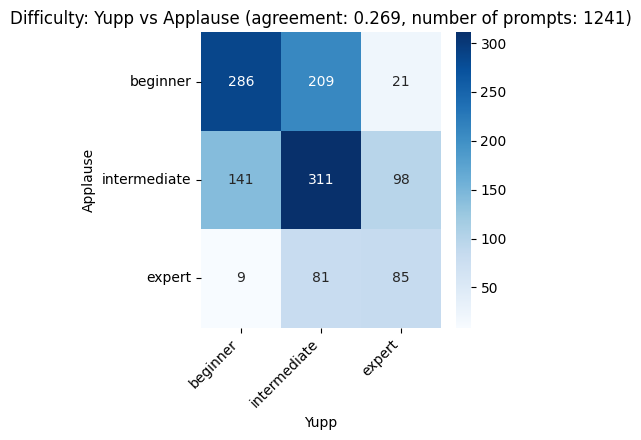

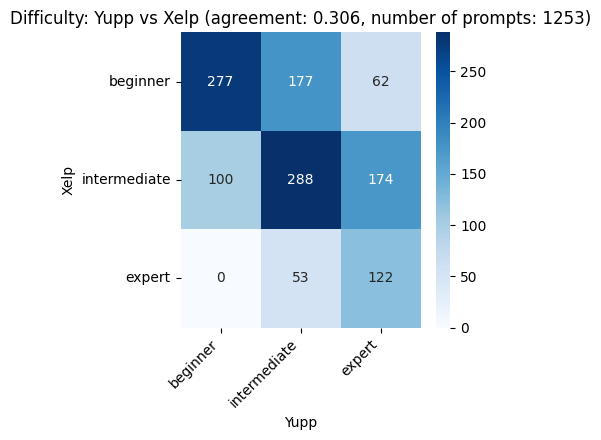

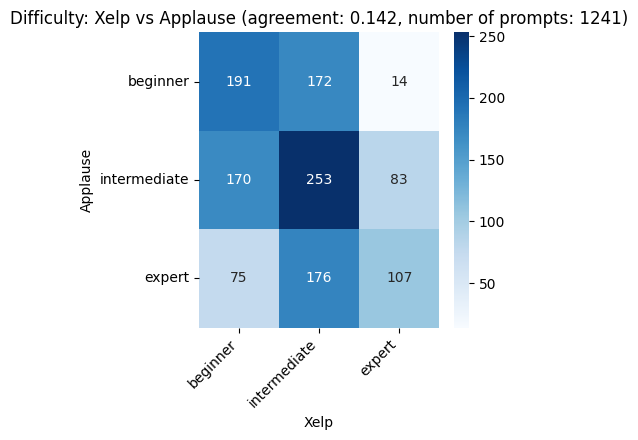

In [8]:
compare(df, 'yupp', 'applause', 'difficulty')
compare(df, 'yupp', 'xelp', 'difficulty')
compare(df, 'xelp', 'applause', 'difficulty')

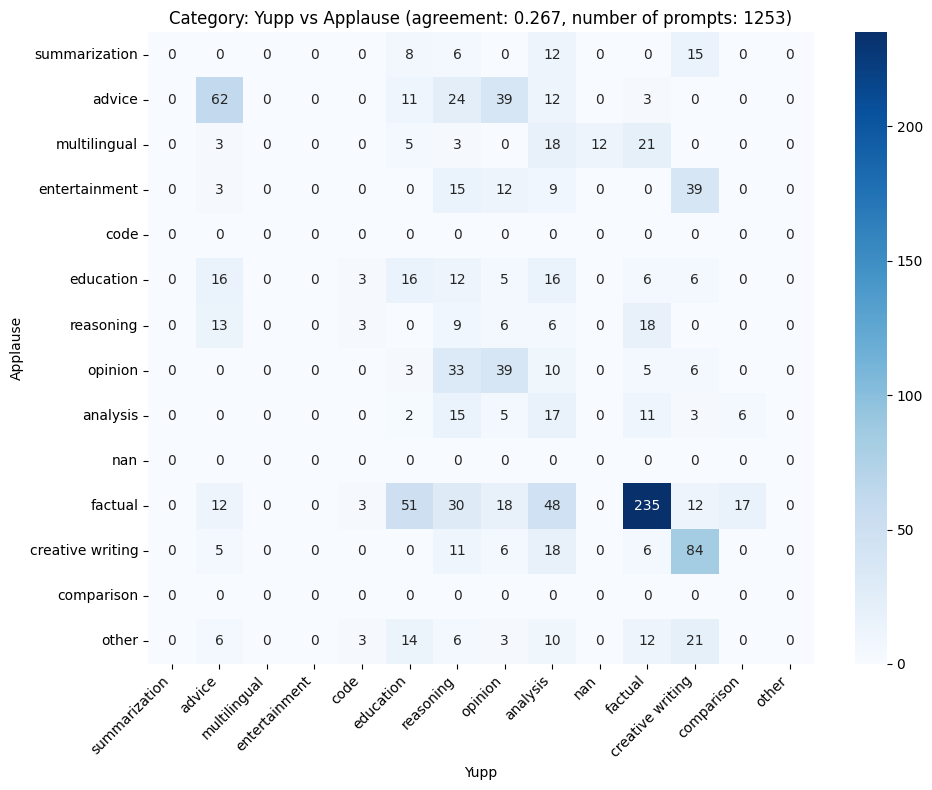

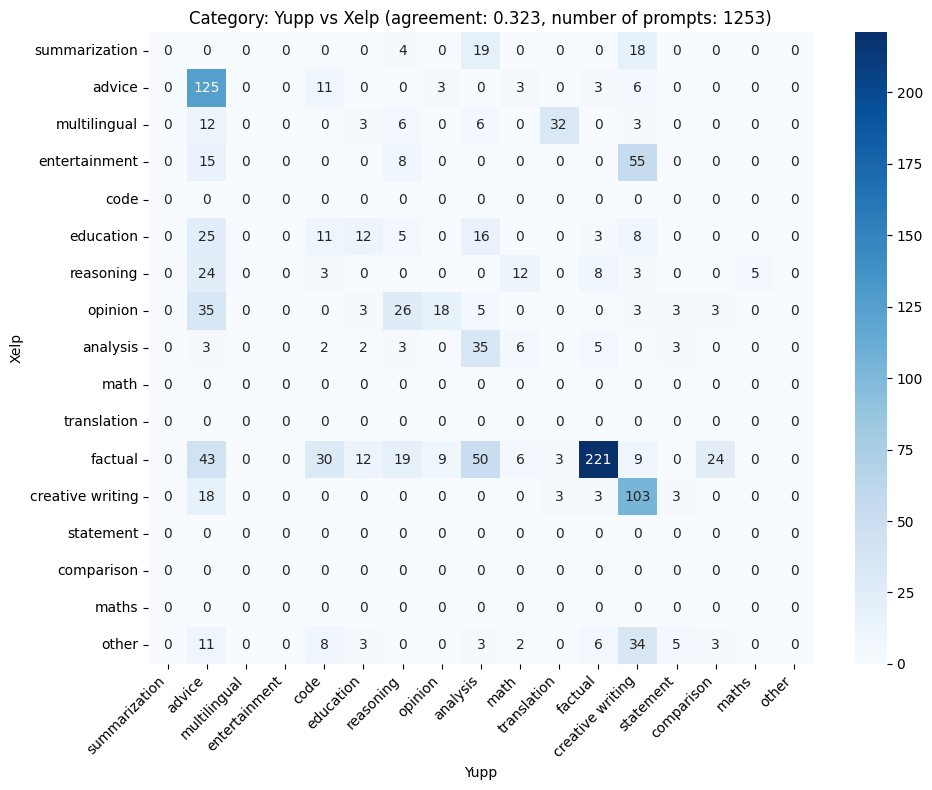

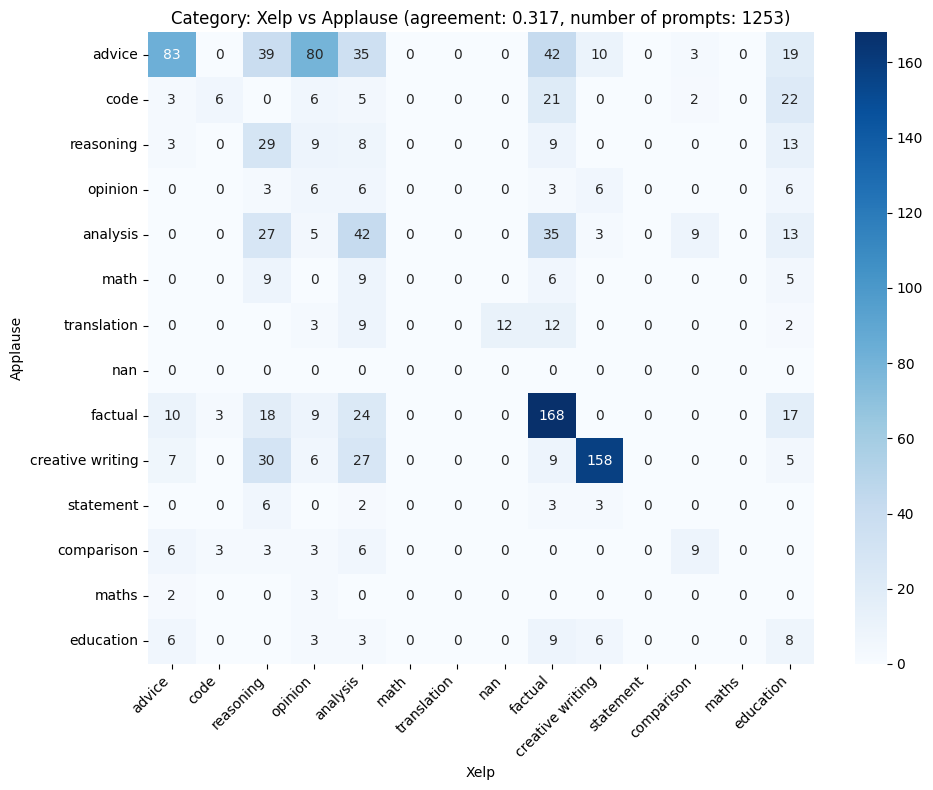

In [9]:
compare(df, 'yupp', 'applause', 'category')
compare(df, 'yupp', 'xelp', 'category')
compare(df, 'xelp', 'applause', 'category')

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

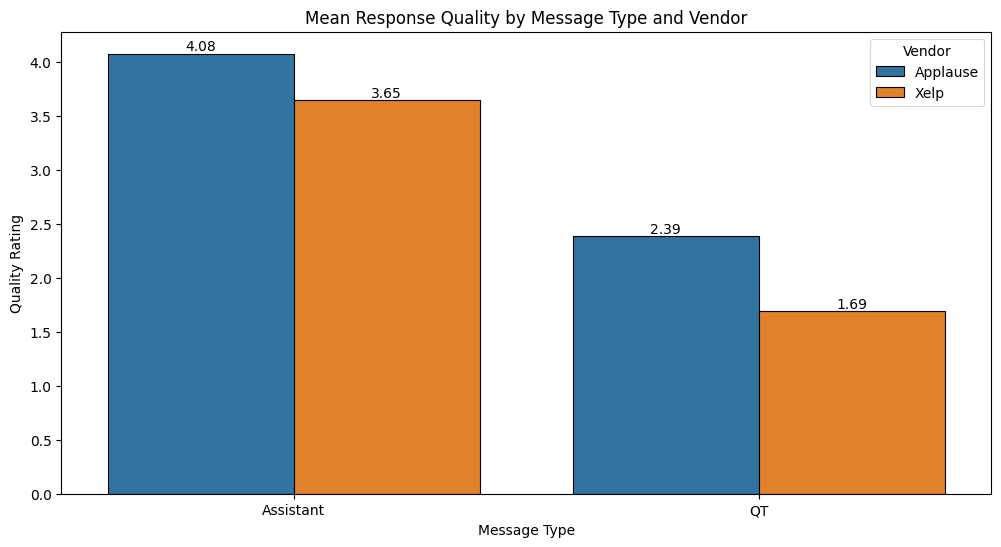

In [10]:
plt.figure(figsize=(12, 6))

dfqt = df[~((df['source'] == 'qt_and_normal') & (df['response_message_type'] == 'quick_response_message'))]

# Create separate dataframes for each combination and reset indices
assistant_xelp = pd.DataFrame({
    'Quality Rating': df[df['response_message_type'] == 'assistant_message']['response_quality_xelp'].astype(float),
    'Message Type': 'Assistant',
    'Vendor': 'Xelp'
}).reset_index(drop=True)

assistant_applause = pd.DataFrame({
    'Quality Rating': df[df['response_message_type'] == 'assistant_message']['response_quality_applause'].astype(float),
    'Message Type': 'Assistant',
    'Vendor': 'Applause'
}).reset_index(drop=True)

quick_xelp = pd.DataFrame({
    'Quality Rating': df[df['response_message_type'] == 'quick_response_message']['response_quality_xelp'].astype(float),
    'Message Type': 'QT',
    'Vendor': 'Xelp'
}).reset_index(drop=True)

quick_applause = pd.DataFrame({
    'Quality Rating': df[df['response_message_type'] == 'quick_response_message']['response_quality_applause'].astype(float),
    'Message Type': 'QT',
    'Vendor': 'Applause'
}).reset_index(drop=True)

# Combine all dataframes
plot_data = pd.concat([assistant_xelp, assistant_applause, quick_xelp, quick_applause], ignore_index=True)

means = plot_data.groupby(['Message Type', 'Vendor'])['Quality Rating'].mean().round(2)

plt.figure(figsize=(12, 6))

def add_means(ax):
    for i, message_type in enumerate(['Assistant', 'QT']):
        for j, vendor in enumerate(['Applause', 'Xelp']):
            mean = means[message_type][vendor]
            # Position text above each box
            ax.text(i, mean, f'{mean:.2f}', 
                   horizontalalignment='center',
                   verticalalignment='bottom')
# Create bar plot of means
plt.figure(figsize=(12, 6), dpi=100)
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['patch.linewidth'] = 0.8
plt.rcParams['patch.facecolor'] = 'white'
plt.rcParams['patch.edgecolor'] = 'black'
plt.rcParams['boxplot.flierprops.markersize'] = 4
plt.rcParams['boxplot.flierprops.markerfacecolor'] = 'white'
plt.rcParams['boxplot.flierprops.markeredgecolor'] = 'black'
plt.rcParams['boxplot.boxprops.linewidth'] = 0.8
plt.rcParams['boxplot.whiskerprops.linewidth'] = 0.8
plt.rcParams['boxplot.capprops.linewidth'] = 0.8
plt.rcParams['boxplot.medianprops.linewidth'] = 0.8

means_df = means.reset_index()
sns.barplot(data=means_df, x='Message Type', y='Quality Rating', hue='Vendor')
plt.title('Mean Response Quality by Message Type and Vendor')

# Add text annotations for the means
for i, message_type in enumerate(['Assistant', 'QT']):
    for j, vendor in enumerate(['Applause', 'Xelp']):
        mean = means[message_type][vendor]
        # Position text above each bar
        plt.text(i - 0.2 + (j*0.4), mean, f'{mean:.2f}', 
                horizontalalignment='center',
                verticalalignment='bottom')
plt.show()
